In [1]:
import xarray
import fiasco
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.visualization import LogStretch, ImageNormalize, quantity_support, time_support
import astropy.table
from demcmc import EmissionLine, TempBins, ContFuncDiscrete, plot_emission_loci, predict_dem_emcee
from xrtpy.response import TemperatureResponseFundamental
import cycler
from synthesizAR.instruments.sdo import _TEMPERATURE_RESPONSE as AIA_TEMPERATURE_RESPONSE

In [2]:
ac1 = cycler.cycler(color=["#0A9F9D", "#CEB175", "#E54E21", "#6C8645", "#C18748"])
ac2 = cycler.cycler(color=["#C52E19", "#AC9765", "#54D8B1", "#b67c3b", "#175149", "#AF4E24"])
ac3 = cycler.cycler(color=["#FBA72A", "#D3D4D8", "#CB7A5C", "#5785C1"])
ac3_alt = cycler.cycler(color=["#5785C1", "#FBA72A",  "#CB7A5C", "#D3D4D8", ])
darjeeling = cycler.cycler(color=["#FF0000", "#00A08A", "#F2AD00", "#F98400", "#5BBCD6"])

# Analysis

In this notebook, perform density diagnostics, DEM inversion, intensity ratio, and time-lag analysis

In [7]:
eis_ds = xarray.open_dataset('../pipeline/data/EIS/loop_cutouts_no_background.nc')

In [8]:
aia_ds = xarray.open_dataset('../pipeline/data/AIA/loop_cutouts_no_background.nc')

In [9]:
xrt_ds = xarray.open_dataset('../pipeline/data/XRT/loop_cutouts_no_background.nc')

## Density Diagnostic

In [36]:
def get_line_ratio(ion, density, numerator_transitions, denominator_transitions, **kwargs):
    """
    For a given ion and a range of densities, calculate the intensity ratio for a selected
    set of transitions at the formation temperature of the ion.
    """
    # Create a new Ion instance with a single temperature at the formation temperature
    ion = ion._new_instance(temperature=ion.formation_temperature)
    # Calculate contribution function
    g_of_nt = ion.contribution_function(density, **kwargs)
    # Get corresponding wavelengths
    w = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    # Find indices corresponding to numerator and denominator
    # NOTE: these are the closest wavelengths to those specified.
    i_numerator = [np.argmin(np.fabs(w - t)) for t in numerator_transitions]
    i_denominator = [np.argmin(np.fabs(w - t)) for t in denominator_transitions]
    # Take ratio of sums over numerator and denominator transitions
    ratio = g_of_nt[..., i_numerator].sum(axis=2) / g_of_nt[..., i_denominator].sum(axis=2)
    return ratio.squeeze()

In [37]:
def make_density_map(observed_ratio, density, intensity_ratio):
    """
    For a given intensity ratio curve and two associated intensity maps, calculate the resulting
    density map.
    """
    f_ratio_to_density = interp1d(intensity_ratio.decompose().value,
                                  density.value,
                                  bounds_error=False,
                                  fill_value=np.nan)
    observed_density = f_ratio_to_density(observed_ratio.data)
    observed_density = xarray.DataArray(observed_density, coords=observed_ratio.coords)
    observed_density.attrs['unit'] = density.unit.to_string()
    
    return observed_density

In [38]:
density = np.logspace(7,12,20) * u.Unit('cm-3')
temperature = np.linspace(1,2,1000)*u.MK
fe12 = fiasco.Ion('Fe XII', temperature)
fe13 = fiasco.Ion('Fe XIII', temperature)

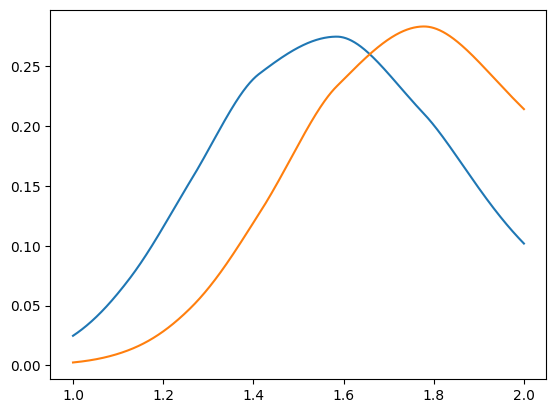

In [39]:
plt.plot(fe12.temperature, fe12.ioneq)
plt.plot(fe13.temperature, fe13.ioneq)

In [40]:
intensity_ratio_fe12 = get_line_ratio(fe12, density, [186.854, 186.887] * u.angstrom, [195.119] * u.angstrom)
intensity_ratio_fe13 = get_line_ratio(fe13, density, [203.795, 203.826] * u.angstrom, [202.044] * u.angstrom)

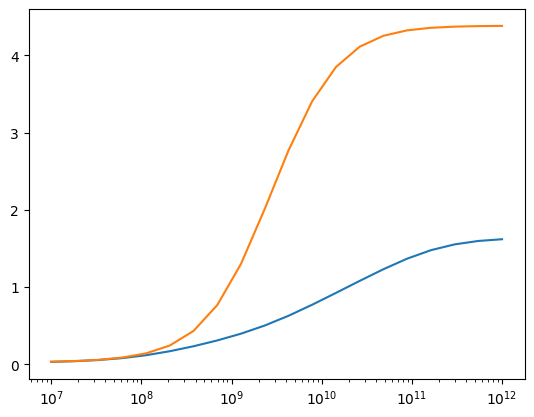

In [41]:
plt.plot(density, intensity_ratio_fe12)
plt.plot(density, intensity_ratio_fe13)
plt.xscale('log')

In [9]:
observed_ratio_fe12 = eis_ds['Fe XII 186.880_intensity'] / eis_ds['Fe XII 195.119_intensity']
observed_ratio_fe13 = eis_ds['Fe XIII 203.826_intensity'] / eis_ds['Fe XIII 202.044_intensity']

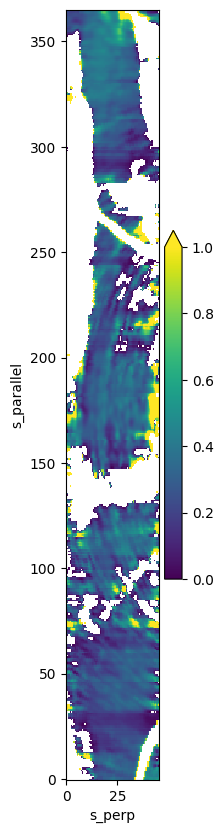

In [10]:
observed_ratio_fe12.plot.imshow(size=10, aspect=0.15, vmin=0, vmax=1)

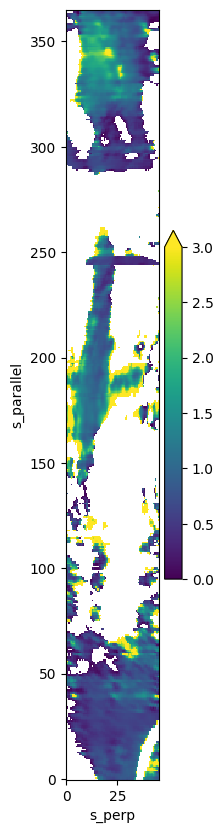

In [11]:
observed_ratio_fe13.plot.imshow(size=10, aspect=0.15, vmin=0, vmax=3)

In [12]:
f_ratio_to_density = interp1d(intensity_ratio_fe12.decompose().value,
                              density.value,
                              bounds_error=False,
                              fill_value=np.nan)
observed_density_fe12 = f_ratio_to_density(observed_ratio_fe12.data)
observed_density_fe12 = xarray.DataArray(observed_density_fe12, coords=observed_ratio_fe12.coords)

In [13]:
observed_density_fe12 = make_density_map(observed_ratio_fe12, density, intensity_ratio_fe12)

In [14]:
observed_density_fe13 = make_density_map(observed_ratio_fe13, density, intensity_ratio_fe13)

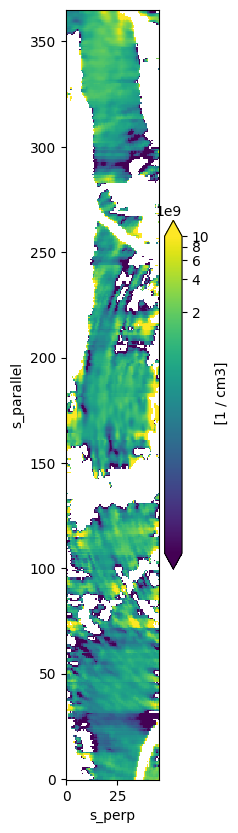

In [15]:
observed_density_fe12.plot.imshow(size=10, aspect=0.15, norm=ImageNormalize(vmin=1e8, vmax=1e10, stretch=LogStretch()))

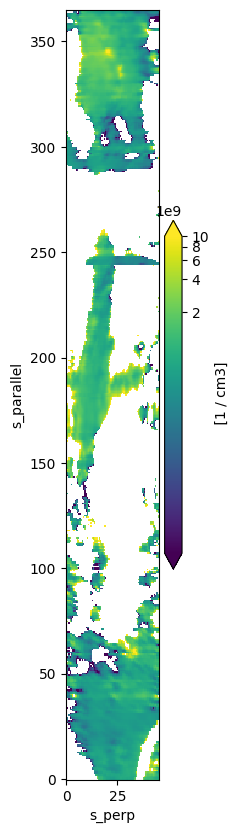

In [16]:
observed_density_fe13.plot.imshow(size=10, aspect=0.15, norm=ImageNormalize(vmin=1e8, vmax=1e10, stretch=LogStretch()))

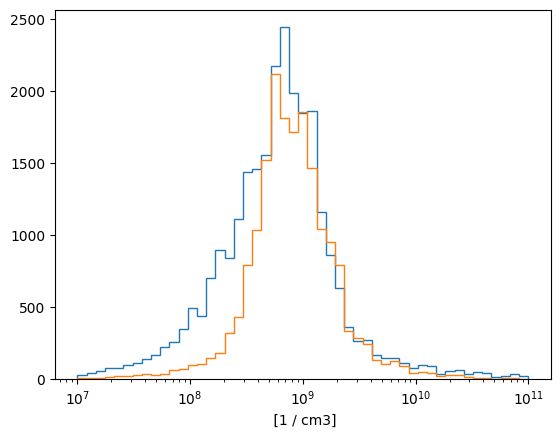

In [17]:
bins = np.logspace(7,11,50)
observed_density_fe12.plot.hist(bins=bins, histtype='step')
observed_density_fe13.plot.hist(bins=bins, histtype='step')
plt.xscale('log')

## Filter Ratio

In [192]:
filter_ratio = aia_ds['193'] / aia_ds['171']

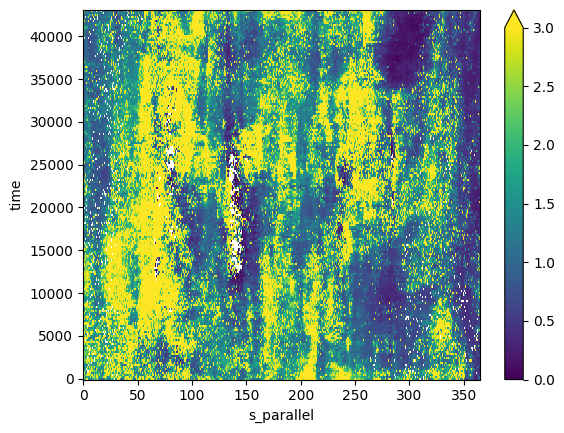

In [195]:
filter_ratio.mean(dim='s_perp',skipna=True).plot.imshow(vmin=0,vmax=3)

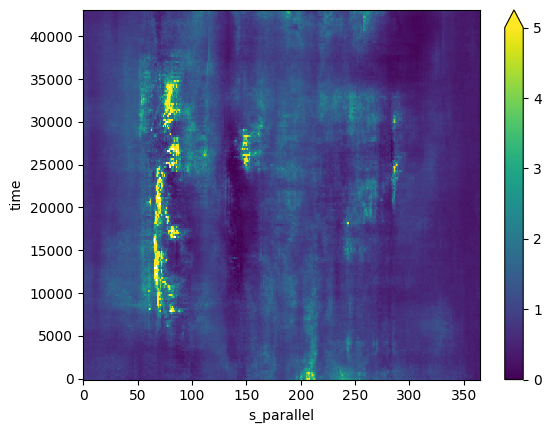

In [199]:
(aia_ds['193'].mean(dim='s_perp',skipna=True) / aia_ds['171'].mean(dim='s_perp', skipna=True)).plot.imshow(vmin=0,vmax=5)

(0.0, 3.0)

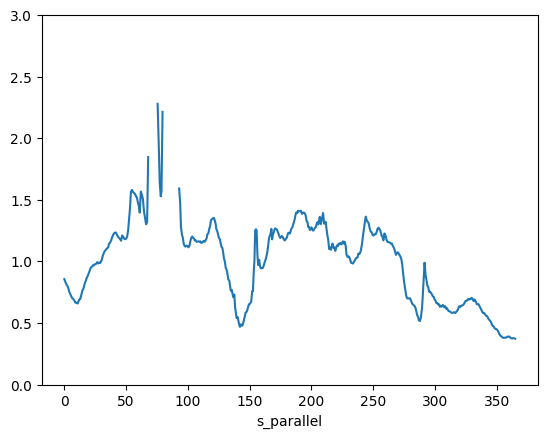

In [201]:
(aia_ds['193'].mean(dim='s_perp',skipna=True) / aia_ds['171'].mean(dim='s_perp', skipna=True)).mean(dim='time',skipna=True).plot()
plt.ylim(0,3)

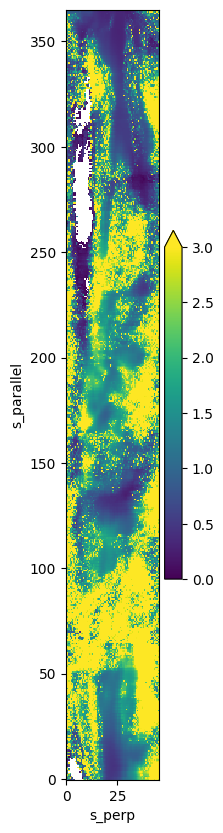

In [14]:
filter_ratio.mean(dim='time', skipna=True).plot.imshow(size=10, aspect=0.15, vmin=0, vmax=3)

In [15]:
anynanmask = np.isnan(filter_ratio).any(dim='time')

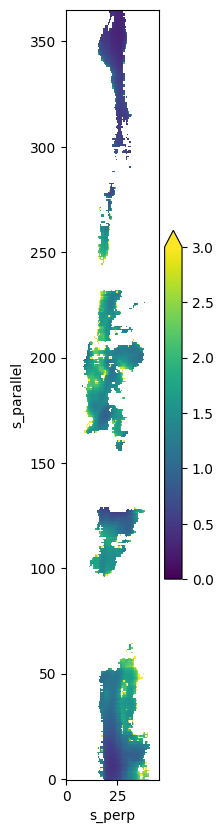

In [20]:
xarray.where(anynanmask, np.nan, filter_ratio).mean(dim='time', skipna=True).plot.imshow(vmin=0, vmax=3, size=10, aspect=0.15)

(0.0, 5.0)

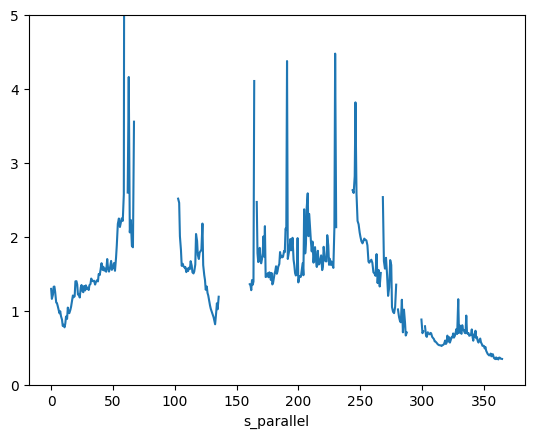

In [47]:
xarray.where(anynanmask, np.nan, filter_ratio).mean(dim=['time','s_perp'], skipna=True).plot()
plt.ylim(0,5)

/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


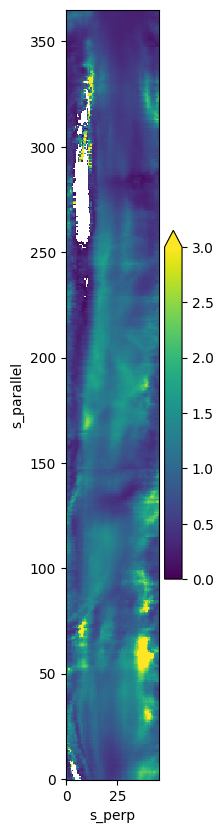

In [34]:
mean_193 = aia_ds['193'].mean(dim=['time'], skipna=True)
mean_171 = aia_ds['171'].mean(dim=['time'], skipna=True)
ratio_193_171 = mean_193 / mean_171
std_193 = aia_ds['193'].std(dim=['time'], skipna=True)
std_171 = aia_ds['171'].std(dim=['time'], skipna=True)
std_ratio = ratio_193_171 * np.sqrt((std_193/mean_193)**2 + (std_171/mean_171)**2)
ratio_193_171.plot.imshow(size=10, aspect=0.15, vmax=3, vmin=0)

(0.0, 3.0)

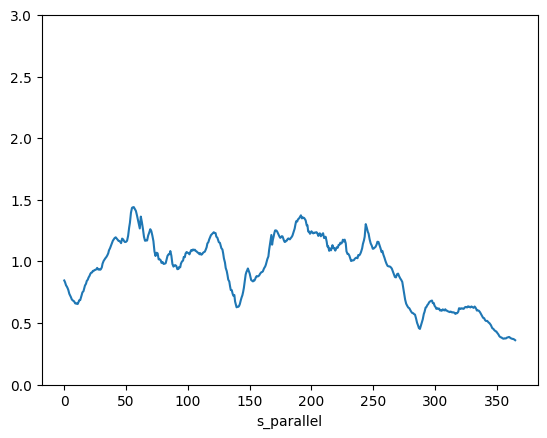

In [46]:
mean_193 = aia_ds['193'].mean(dim=['time','s_perp'], skipna=True)
mean_171 = aia_ds['171'].mean(dim=['time','s_perp'], skipna=True)
ratio_193_171 = mean_193 / mean_171
std_193 = aia_ds['193'].std(dim=['time','s_perp'], skipna=True)
std_171 = aia_ds['171'].std(dim=['time','s_perp'], skipna=True)
std_ratio = ratio_193_171 * np.sqrt((std_193/mean_193)**2 + (std_171/mean_171)**2)
ratio_193_171.plot()
plt.ylim(0,3)

## DEM Analysis

Select the EIS lines appropriate for DEM analysis

In [10]:
selected_keys = [
    #'Al IX 284.015_intensity',
    #'Ar XI 188.806_intensity',
    #'Ar XIV 187.964_intensity',
    #'Ar XIV 194.396_intensity',
    #'Ca XIV 193.874_intensity',
    #'Ca XV 200.972_intensity',
    'Ca XVII 192.858_intensity',
    'Fe VIII 185.213_intensity',
    'Fe VIII 186.601_intensity',
    #'Fe IX 188.497_intensity',
    #'Fe IX 197.862_intensity',
    'Fe X 184.536_intensity',
    'Fe X 193.715_intensity',
    'Fe XI 180.401_intensity',
    'Fe XI 188.216_intensity',
    'Fe XI 188.299_intensity',
    'Fe XI 192.813_intensity',
    'Fe XII 186.880_intensity',
    'Fe XII 192.394_intensity',
    'Fe XII 195.119_intensity',
    #'Fe XII 195.179_intensity',
    #'Fe XII 203.720_intensity',
    #'Fe XIII 201.121_intensity',
    'Fe XIII 202.044_intensity',
    'Fe XIII 203.826_intensity',
    'Fe XIV 264.787_intensity',
    'Fe XIV 270.519_intensity',
    'Fe XV 284.160_intensity',
    #'Fe XVI 262.984_intensity',
    #'Fe XXIV 192.040_intensity',
    'Mg VI 270.394_intensity',
    #'Mn X 194.327_intensity',
    #'O V 192.906_intensity',
    #'S XI 188.675_intensity',
    #'S XIII 256.686_intensity',
    #'Si VII 275.368_intensity',
    #'Si VII 275.665_intensity',
    'Si X 258.375_intensity',
]

Organize intensities and responses into tables, selecting the intensity from the location where the Fe XII emission is maximized

In [11]:
i_max = np.argmax(eis_ds['Fe XII 195.119_intensity'].mean(dim='s_parallel', skipna=True).data)

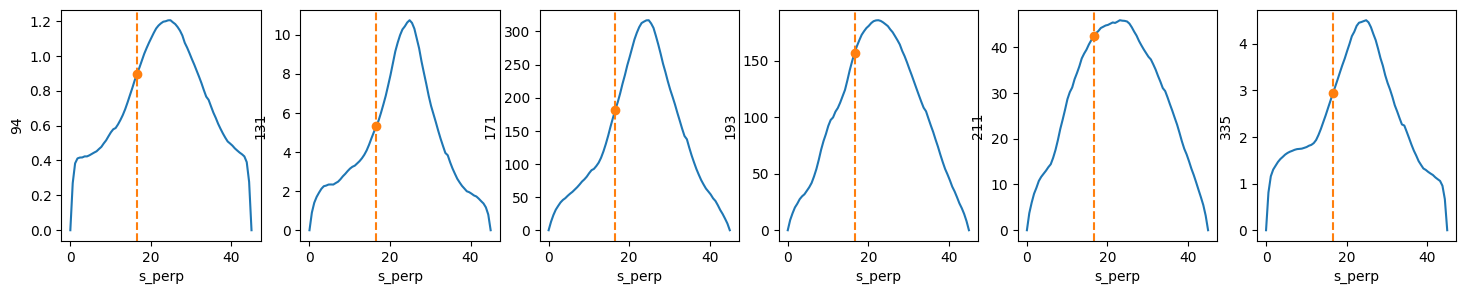

In [12]:
fig,axes = plt.subplots(1,6,figsize=(18,3),sharex=True,)
for k,ax in zip(aia_ds.keys(), axes.flatten()):
    mean_intensity = aia_ds[k].mean(dim=['time', 's_parallel'], skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

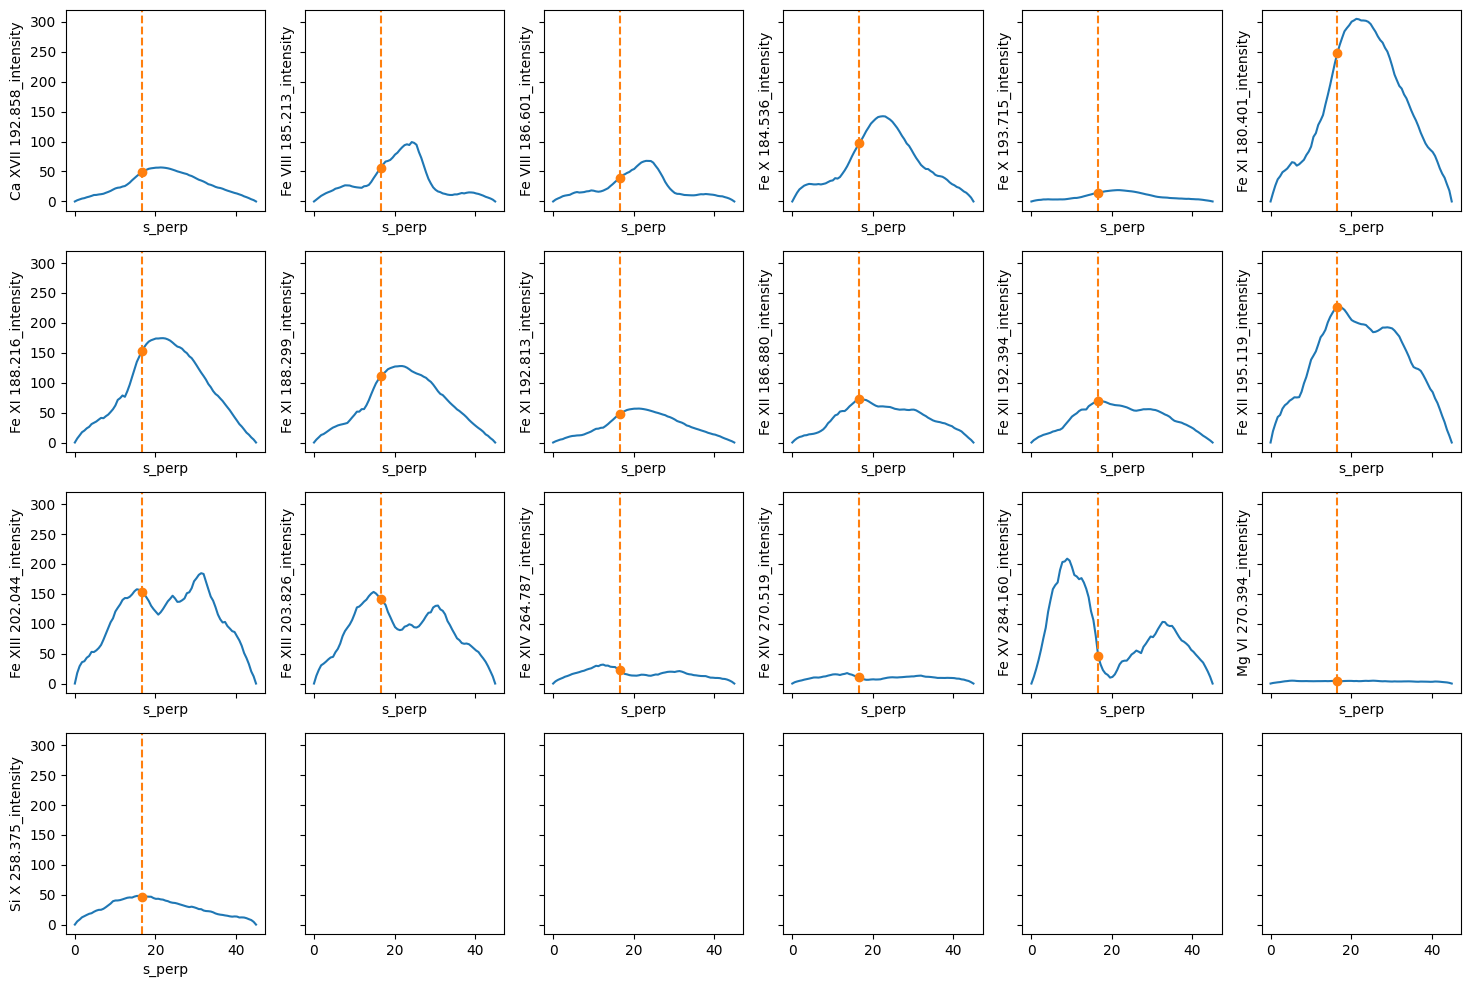

In [13]:
fig,axes = plt.subplots(4,6,figsize=(18,12),sharex=True, sharey=True)
for k,ax in zip(selected_keys, axes.flatten()):
    mean_intensity = eis_ds[k].mean(dim='s_parallel', skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

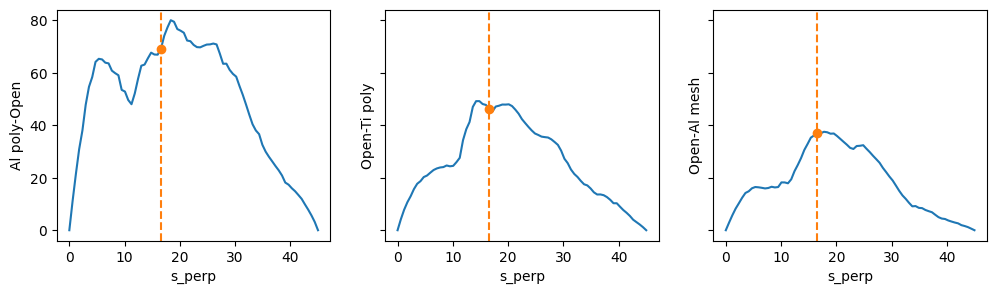

In [17]:
fig,axes = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)
for k,ax in zip(xrt_ds.keys(), axes.flatten()):
    mean_intensity = xrt_ds[k].mean(dim=['s_parallel'], skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

In [18]:
lines = [k.split('_')[0].split() for k in selected_keys]
ions = [' '.join(l[:2]) for l in lines]
transitions = u.Quantity([float(l[2]) for l in lines], 'Angstrom')
line_table = astropy.table.QTable({'Ion': ions, 'Transition': transitions})
line_table['Element'] = list(map(lambda x: x.split()[0], line_table['Ion']))

In [20]:
delta_log_T = 0.02
temperature = 10**np.arange(5.3, 7.3+delta_log_T, delta_log_T)*u.K
density = 1e15*u.Unit('K cm-3') / temperature
ion_objects = {iname: fiasco.Ion(iname, temperature) for iname in np.unique(line_table['Ion'])}
goft = {k: v.contribution_function(density, couple_density_to_temperature=True) for k,v in ion_objects.items()}

In [48]:
eis_to_chianti_mapping = {
    186.880*u.Angstrom: 186.887*u.Angstrom,
}

In [53]:
goft_col = []
for row in line_table:
    waves = ion_objects[row['Ion']].transitions.wavelength[~ion_objects[row['Ion']].transitions.is_twophoton]
    eis_wavelength = eis_to_chianti_mapping.get(row['Transition'], row['Transition'])
    iwave = int(np.argmin(np.fabs(waves - eis_wavelength)))
    goft_col.append(goft[row['Ion']][..., iwave].squeeze())
goft_col = u.Quantity(goft_col)
line_table['Response'] = goft_col
line_table['Temperature'] = [temperature,]

In [191]:
line_table

Ion,Transition,Element,Contribution function,Temperature,Intensity
,Angstrom,,cm3 erg / s,K,erg / (s cm2)
str7,float64,str2,float64[40],float64[40],float64
Ca XVII,192.858,Ca,0.0 .. 1.3934472555598287e-27,316227.7660168379 .. 28183829.312644087,611.9031586352284
Fe VIII,185.213,Fe,2.258893949849644e-24 .. 0.0,316227.7660168379 .. 28183829.312644087,694.2043952379604
Fe VIII,186.601,Fe,1.6033865114178366e-24 .. 0.0,316227.7660168379 .. 28183829.312644087,491.6914080371505
Fe X,184.536,Fe,8.961933329209995e-29 .. 0.0,316227.7660168379 .. 28183829.312644087,1223.1642771416848
Fe X,193.715,Fe,3.1220908397429446e-29 .. 0.0,316227.7660168379 .. 28183829.312644087,182.40989560888488
Fe XI,180.401,Fe,4.7873114044118676e-32 .. 0.0,316227.7660168379 .. 28183829.312644087,3106.1979637654085
Fe XI,188.216,Fe,2.77124271163051e-32 .. 0.0,316227.7660168379 .. 28183829.312644087,1909.6705787609749
Fe XI,188.299,Fe,1.569860379074978e-32 .. 0.0,316227.7660168379 .. 28183829.312644087,1389.7468956259163


In [166]:
element_colors = {el: color['color'] for el,color in zip(np.unique(line_table['Element']), darjeeling)}

(316227.7660168379, 28183829.312644087)

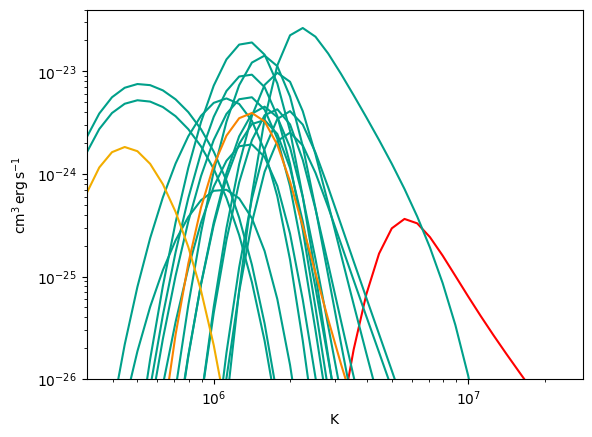

In [167]:
with quantity_support():
    for row in line_table:
        plt.plot(row['Temperature'], row['Contribution function'], color=element_colors[row['Element']])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-26, 4e-23)
plt.xlim(temperature[[0,-1]])

In [56]:
intensity = []
for row in line_table:
    key = f'{row["Ion"]} {row["Transition"].to_value("Angstrom"):.03f}_intensity'
    I_obs = u.Quantity(eis_ds[key].mean(dim='s_parallel', skipna=True).data[i_max], eis_ds[key].attrs['bunit'])
    intensity.append(I_obs)
intensity = u.Quantity(intensity) * 4 * np.pi * u.steradian
line_table['Intensity'] = intensity

In [57]:
trf_al_poly = TemperatureResponseFundamental('Al-poly', aia_ds['171'].attrs['date-obs'])
trf_ti_poly = TemperatureResponseFundamental('Ti-poly', aia_ds['171'].attrs['date-obs'])
trf_al_mesh = TemperatureResponseFundamental('Al-mesh', aia_ds['171'].attrs['date-obs'])

In [142]:
xrt_table = astropy.table.QTable({'Filter':[], 'Intensity': []}, dtype=[str, float])
xrt_table['Intensity'].unit = 'ct pix-1 s-1'
response_row = []
for k, trf in [('Al poly-Open', trf_al_poly), ('Open-Ti poly', trf_ti_poly), ('Open-Al mesh', trf_al_mesh)]:
    xrt_table.add_row({
        'Filter': k,
        'Intensity': u.Quantity(xrt_ds[k].mean(dim='s_parallel', skipna=True)[i_max].data, xrt_ds[k].attrs['bunit']) / u.pix
    })
    response_row.append(2*trf.temperature_response()/u.DN*u.ct)
xrt_table['Temperature'] = [trf.CHIANTI_temperature,]
xrt_table['Response'] = response_row

In [143]:
aia_table = astropy.table.QTable({'Filter':[], 'Intensity': []}, dtype=[str, float])
aia_table['Intensity'].unit = 'ct pix-1 s-1'
response_row = []
for k in aia_ds:
    aia_table.add_row({
        'Filter': k,
        'Intensity': u.Quantity(aia_ds[k].mean(dim=['s_parallel', 'time'], skipna=True)[i_max].data, aia_ds[k].attrs['bunit']) / u.pix,
        #'Response': AIA_TEMPERATURE_RESPONSE[k],
    })
    response_row.append(AIA_TEMPERATURE_RESPONSE[k])
aia_table['Temperature'] = [AIA_TEMPERATURE_RESPONSE['temperature'],]
aia_table['Response'] = response_row

(316227.7660168379, 28183829.312644087)

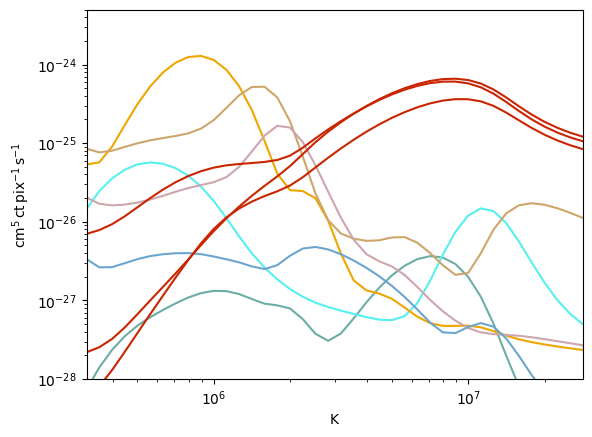

In [189]:
with quantity_support():
    for row in aia_table:
        plt.plot(row['Temperature'], row['Response'],color=plt.get_cmap(f'sdoaia{row["Filter"]}')(0.65), label=f'AIA {row["Filter"]} Å')
    for row in xrt_table:
        plt.plot(row['Temperature'], row['Response'],color=plt.get_cmap('hinodexrt')(0.55),)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-28, 5e-24)
plt.xlim(temperature[[0,-1]])
#plt.legend()

/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


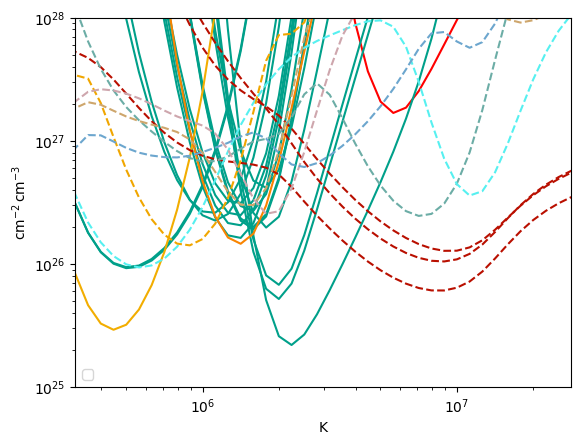

In [190]:
with quantity_support():
    # EIS
    for row in line_table:
        em_loci = row['Intensity']/row['Contribution function']
        plt.plot(temperature, em_loci, color=element_colors[row['Element']], ls='-')
    # XRT
    for row in xrt_table:
        plt.plot(row['Temperature'], row['Intensity']/row['Response'], color=plt.get_cmap('hinodexrt')(0.5), ls='--')
    # AIA
    for row in aia_table:
        plt.plot(row['Temperature'], row['Intensity']/row['Response'], color=plt.get_cmap(f'sdoaia{row["Filter"]}')(0.65), ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e25,1e28)
plt.xlim(temperature[[0,-1]])
plt.legend()